# Aula prática - Filtros
* Disciplina: Sistemas de comunicação
* Professor: Carmelo José Albanez Bastos Filho
* Estagiário: Gabriel Alves de Lima (gal@ecomp.poli.br)

## O que são filtros?
Filtros são componentes que são capazes de remover componentes indesejados ou evidenciar características de um sinal. Em sistemas de comunicação, são normalmente utilizados para *separar componentes de informação* ou *corrigir distorções*, por exemplo. Um filtro de linhas transversais funciona pela _convolução_ do sinal de entrada com seus coeficientes, ou seja, as amostras do sinal de entrada são colocadas, uma a uma, em linhas de atraso ponderadas e seus resultados são somados.

<figure class="image">
  <img src="static/image/filtro_transversal.png" alt="Diagrama de blocos de um filtro de linhas transversais">
  <figcaption>Figura 1: Diagrama de blocos de um filtro de linhas transversais</figcaption>
</figure>

Vamos ver na aula de hoje como podemos implementar filtros (utilizando python) e utilizá-los para remover dados indesejados de sinais.

## Sinais
Antes de estudarmos diretamente com filtros, vamos primeiro entender como podemos representar sinais. Assim, poderemos criar diferentes sinais para filtrarmos mais adiante.

### Amostragem
Os sinais não podem ser representados como sinais contínuos dentro de um computador, pois simplesmente não existe memória infinita para representar o domínio (e.g. tempo) sem antes definir uma maneira de tornar este discreto. Existe, no entanto, uma forma simples de pensar nisso.
Amostrar um sinal é representar este como uma sequência de amostras espaçadas igualmente. Desta forma, desde que o formato de onda seja mantido, as mesmas informações que estão presentes no sinal de domínio contínuo também estarão presentes no sinal de domínio discreto. Isto pode ser visto na Figura 2. A representação matemática da amostragem é a multiplicação de um sinal por um trem de impulsos separados entre si por um multiplo de uma constante (i.e. o período de amostragem).

<figure class="image">
  <img src="static/image/sinal_amostragem.png" alt="Amostragem de um sinal por um trem de impulsos">
  <figcaption>Figura 2: Amostragem de um sinal por um trem de impulsos.</figcaption>
</figure>

### Teorema da amostragem
Para que o formato de onda de um sinal após a coleta das amostras, existe um critério que é definido pelo chamado *teorema da amostragem* que indica a frequência mínima (ou período máximo) do trem de impulsos para que não ocorra perda de informação durante este processo. O critério define que *a taxa mínima de amostragem deve ser igual a frequência máxima presente no sinal*. Podemos assim citar alguns exemplos para demonstrar a aplicabilidade deste critério:
* Uma chamada telefônica tem como taxa de amostragem 8kHz, pois a voz humana muito dificilmente pode superar a marca de 4kHz. Logo, a frequência mínima de amostragem é de 8kHz.
* A taxa de amostragem de um CD de áudio é de 44.1kHz, pois a frequência máxima que o ouvido de um ser humano pode ouvir é de 20kHz, então, a taxa de amostragem mínima para poder representar todo a banda audível é de 40kHz.

### Implementação de sinais
Vamos começar a fazer um pouco de prática (usaremos python aqui). Primeiramente, vamos importar todas as bibliotecas necessárias para executarmos os experimentos. Basicamente vamos utilizar apenas 3 bibliotecas:
* *numpy*: criação de dados sintéticos (e.g. para criar os sinais) e operações matemáticas em coleções de dados.
* *scipy*: acesso a funções de auxílio para operações com sinais e filtros
* *matplotlib*: visualização dos dados

In [3]:
# Show plots below code (Specific to ipython notebooks)
%matplotlib inline

# Importing everything we are going to need
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile    # Useful for reading .wav audio files
from scipy import signal        # A handful of signal processing operations

Definiremos também algumas funções úteis para visualizar os dados. Não são tão importantes para entendermos o processo, mas precisamos definí-las antes de usarmos.

In [20]:
# Function to plot signal data
def plot_signal(figure, title, labels, data):
    plt.figure(figure)
    plt.title(title)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.plot(data[0], data[1])

# Function to plot filter response
def plot_filter_response(figure, f):
    plt.figure(figure)
    w, h = signal.freqz(f)

    fig, ax1 = plt.subplots()
    ax1.set_title('Digital filter frequency response')

    ax1.plot(w, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')

Como primeiro exemplo, vamos criar sinais senoidais de diferentes frequências e depois criar um sinal mais complexo como a composição destes dois primeiros.

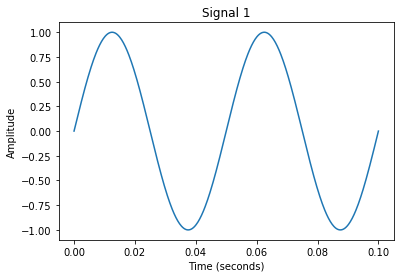

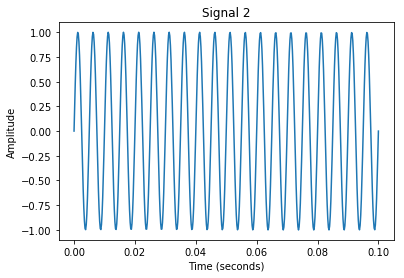

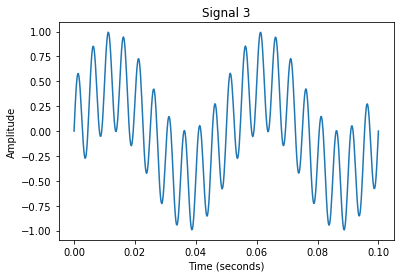

In [42]:
sampling_rate = 5000   # Hz
signal_duration = 0.1  # seconds

sampling_period = 1.0 / sampling_rate   # seconds
signal_domain = np.linspace(0, signal_duration, int(sampling_rate * signal_duration))

f1 = 20     # Hz
f2 = 200     # Hz

s1 = np.sin(2 * np.pi * signal_domain * f1) # A 20Hz sinusoid wave 
s2 = np.sin(2 * np.pi * signal_domain * f2) # A 200Hz sinusoid wave
s3 = 0.5 * s1 + 0.5 * s2   # A compound of the two waves defined earlier

# Plotting each signal
labels = ('Time (seconds)', 'Amplitude')
plot_signal(1, 'Signal 1', labels, (signal_domain, s1))
plot_signal(2, 'Signal 2', labels, (signal_domain, s2))
plot_signal(3, 'Signal 3', labels, (signal_domain, s3))

In [6]:
def convolve(x, h):
    xr = [0] * h.shape[0]
    
    def run(signal, regressor):
        y = []
        for sample in signal:
            regressor.insert(0, sample)
            regressor.pop()
            y.append(np.dot(np.array(regressor), h))
            
        return y
    
    y = run(x, xr) + run(np.zeros(h.shape[0] - 1), xr)
    return np.array(y)

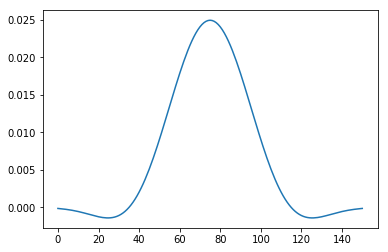

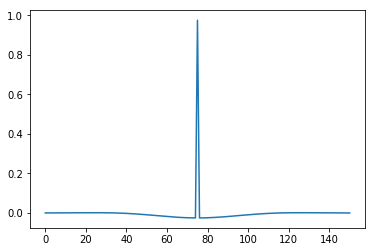

<Figure size 432x288 with 0 Axes>

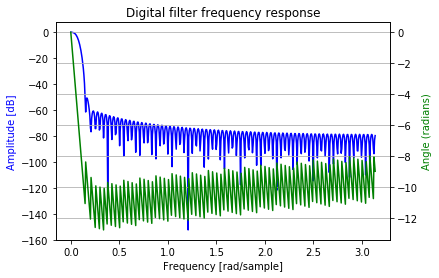

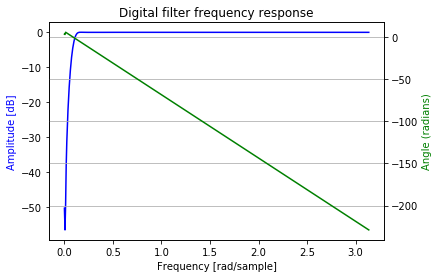

In [25]:
low_pass_filter = signal.firwin(151, 125.0 / sampling_rate)
high_pass_filter = signal.firwin(151, 125.0 / sampling_rate, pass_zero=False)

plt.figure(1)
plt.plot(low_pass_filter)

plt.figure(2)
plt.plot(high_pass_filter)

plot_filter_response(3, low_pass_filter)
plot_filter_response(4, high_pass_filter)

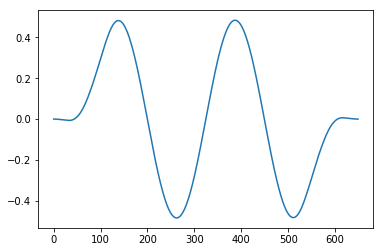

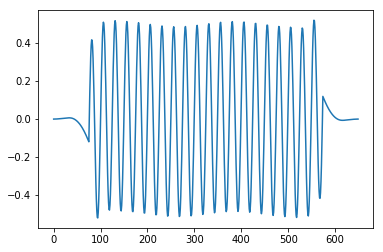

In [26]:
y1 = convolve(s3, low_pass_filter)
y2 = convolve(s3, high_pass_filter)
plt.figure(1)
plt.plot(y1)

plt.figure(2)
plt.plot(y2)

In [6]:
def create_noisy_wavfile(source, target):
    # Read info from source file
    # audio_sampling will be the sampling frequency used to record the file
    # stereo_data is a numpy ndarray with shape (num_samples, num_channels)
    audio_sampling, stereo_data = wavfile.read(source)
    print(audio_sampling, stereo_data.shape, stereo_data[0:10,:])
    
    max_value = np.abs(stereo_data).max()
    num_samples = stereo_data.shape[0]
    num_channels = stereo_data.shape[1]
    audio_duration = num_samples / audio_sampling   # seconds
    
    # Create a 8000Hz sinusoid wave to act as noise
    # Be sure to use the same sampling rate used in the audio file
    # Also, use the number of samples to produce a wave of same duration
    noise_frequency = 8000
    noise_domain = np.linspace(0, audio_duration, num_samples)
    noise = np.sin(2 * np.pi * noise_domain * noise_frequency)
    plt.plot(noise_domain, stereo_data[:,0])
    
    # Normalize data to [-1, 1] range, so it will be easier to write the file after processing it
    # Then, add noise
    normalized_stereo_data = stereo_data / max_value
    channels = []
    for channel in range(num_channels):
        channels.append(0.8 * normalized_stereo_data[:, channel] + 0.2 * noise)
    
    # Stack channels together and denormalize it to write to the target file
    normalized_data = np.stack(channels, axis=1)
    data = (normalized_data * max_value).astype(stereo_data.dtype)
    wavfile.write(target, audio_sampling, data)

44100 (379261, 2) [[ 0  0]
 [ 1  0]
 [ 0  0]
 [-1  0]
 [ 0  0]
 [ 0  0]
 [-1  0]
 [ 0  0]
 [ 1  0]
 [ 0  0]]


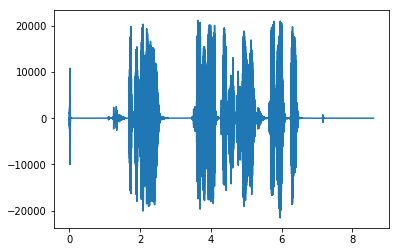

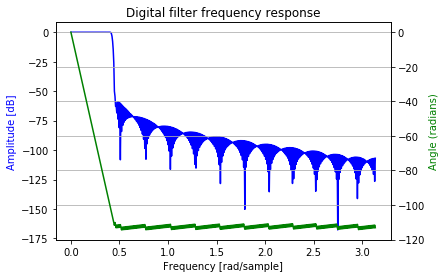

In [7]:
create_noisy_wavfile('static/audio/mom.wav', 'static/audio/noisy_mom.wav')

audio_sampling, stereo_data = wavfile.read('static/audio/noisy_mom.wav')
num_channels = stereo_data.shape[1]
max_value = np.abs(stereo_data).max()
f = signal.firwin(500, 6000.0 / audio_sampling)

w, h = signal.freqz(f)

fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')

ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

normalized_stereo_data = stereo_data / max_value
left_data = normalized_stereo_data[:,0]
right_data = normalized_stereo_data[:,1]
#filtered_left_data = convolve(left_data, f)
#filtered_right_data = convolve(right_data, f)
filtered_left_data = left_data
filtered_right_data = right_data

normalized_data = np.stack((filtered_left_data, filtered_right_data), axis=1)
data = (normalized_data * max_value).astype(stereo_data.dtype)
wavfile.write('static/audio/filtered_mom.wav', audio_sampling, data)